<a href="https://colab.research.google.com/github/joaopcnogueira/colab-notebooks/blob/main/NLP_Supervised_Sentiment_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# 1. Loading Data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [5]:
max(df['message_len'])

171

# 2. EDA

Now we are going to take a look about the target distribution and the messages length.

In [6]:
df.value_counts('target').reset_index().rename(columns={0: 'count'})

,target,count
0,ham,4825
1,spam,747


In [7]:
import plotly.express as px

target_dist = df.value_counts('target').reset_index().rename(columns={0: 'count'})

px.bar(target_dist, x='target', y='count', title='<span style="font-size:32px; font-family: Times New Roman">Target Distribution</span>')

As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.

In [8]:
from plotly import graph_objs as go

ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color='blue',
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color='red',
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the `ham` message length tend to be lower than `spam` message length.

# 3. Data Pre-Processing

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

## 3.1 Cleaning the corpus

In [9]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation and
    remove words containing numbers.'''
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [10]:
df['message_clean'] = df['message'].apply(clean_text)

df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


**Stopwords**

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    
    return text

In [16]:
df['message_clean'] = df['message_clean'].apply(remove_stopwords)

df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


## 3.2 Stemming

As far as the meaning of the words is not important for this study, we will focus on stemming rather than lemmatization.

In [17]:
stemmer = nltk.SnowballStemmer('english')

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [18]:
df['message_clean'] = df['message_clean'].apply(stemm_text)

df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## 3.3 All together

In [19]:
def preprocess_data(text):
    # Clean punctuation, urls, and so on
    text = clean_text(text)
    
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    
    # Stemm all the words in the sequence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [20]:
df['message_clean'] = df['message'].apply(preprocess_data)

df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## 3.4 Target encoding

In [21]:
df['target_encoded'] = df['target'].map({'ham': 0, 'spam': 1})

df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


# 4. Tokens visualization

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

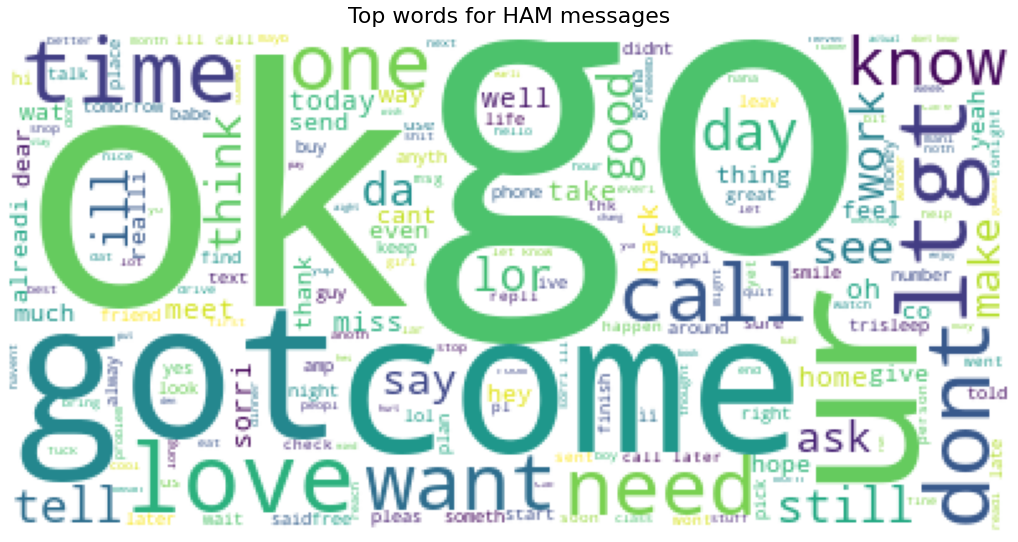

In [23]:
wc = WordCloud(
    background_color='white',
    max_words=200
)

wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean']))

plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

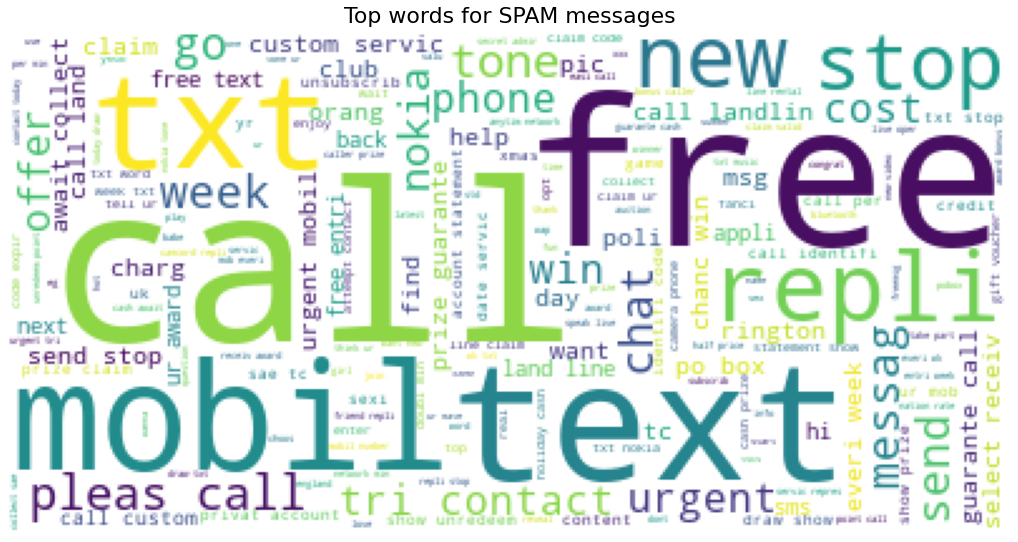

In [24]:
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# 5. Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus. We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.

In [26]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = df['message_clean']
y = df['target_encoded']

print(len(X), len(y))

5572 5572


In [27]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

4179 4179
1393 1393


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [29]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [30]:
X_train_dtm

<4179x5717 sparse matrix of type '<class 'numpy.int64'>'
	with 32431 stored elements in Compressed Sparse Row format>

## 5.1 Tunning CountVectorizer

CountVectorizer has a few parameters you should know.

1. **stop_words**: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

2. **ngram_range**: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1). In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.

3. **min_df, max_df**: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

4. **max_features**: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.

You would set these parameters when initializing your CountVectorizer object as shown below.

In [31]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

## 5.2 TF-IDF

In information retrieval, tf–idf, **TF-IDF**, or TFIDF, **short for term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

**tf–idf** is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<4179x5717 sparse matrix of type '<class 'numpy.float64'>'
	with 32431 stored elements in Compressed Sparse Row format>

## 5.3 Word Embeddings: GloVe

# 6. Modeling

## 6.1 Naive Bayes DTM

In [33]:
# Create a Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
# Make class and probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [35]:
# calculate accuracy of class predictions
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred_class))

0.9784637473079684


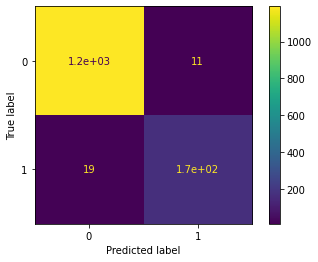

In [36]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(nb, X_test_dtm, y_test);

In [37]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

## 6.2 Nayve Bayes

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.9597989949748744


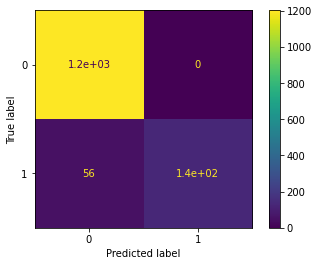

In [39]:
# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_test)

print(accuracy_score(y_test, y_pred_class))

plot_confusion_matrix(pipe, X_test, y_test)

## 6.3 XGBoost

In [40]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
                    learning_rate=0.1,
                    max_depth=7,
                    n_estimators=80,
                    use_label_encoder=False,
                    eval_metric='auc',
                    # colsample_bytree=0.8,
                    # subsample=0.7,
                    # min_child_weight=5,
    ))
])

Train: 0.9834888729361091
Test: 0.9655419956927495


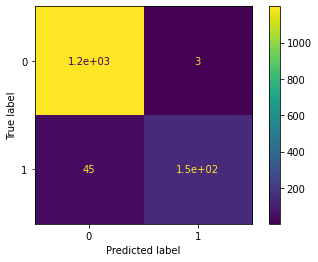

In [42]:
# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class)))

plot_confusion_matrix(pipe, X_test, y_test)